In [243]:
import sys
sys.path.insert(0, '..')

In [244]:
import optimistix as optx


In [245]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)


# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *
from spectra import *

import jax.tree_util as jtu

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [246]:
extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)


In [247]:
wid = 64
oversample = 4

nwavels = 13#6
npoly=10#2

n_zernikes = 30#12

optics = NICMOSOptics(1024, wid, oversample, n_zernikes = n_zernikes)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"

# brown dwarf

files = [
    #'n8yj53vfq_cal.fits',
    #'n8yj53vkq_cal.fits',
    'n8yj02x0q_cal.fits',
    #'n8yj02wyq_cal.fits'

]
"""

# lhs 1846
ddir = "../data/MAST_2025-03-02T22_29_29.259Z/HST/"

files = ["n8ku01ffq_cal.fits", "n8ku01fgq_cal.fits"][:1]

ddir = "../data/MAST_2024-09-08T07_59_18.213Z/HST/"

files = [
    # F095N
    "n43ca5fjq_cal.fits",
    "n43ca5fkq_cal.fits",
    "n43ca5flq_cal.fits",
    "n43ca5fmq_cal.fits",
    #F190N
    "n43ca5feq_cal.fits",
    "n43ca5ffq_cal.fits",
    "n43ca5fgq_cal.fits",
    "n43ca5fhq_cal.fits",
    #F187N
    #"n43c03dnq_cal.fits",
    #"n43c03doq_cal.fits",
    #"n43c03dpq_cal.fits",
    #"n43c03drq_cal.fits",
    #F108N
    #"n43c03dsq_cal.fits",
    #"n43c03duq_cal.fits",
    ##"n43c03dvq_cal.fits",
    ##"n43c03dwq_cal.fits",
][-1:]

# hyades

ddir = "../data/MAST_2024-09-26T22_53_13.719Z/HST/"

files = [
    "n8ry37p8q_cal.fits",
    "n8ry37p9q_cal.fits",

    #"n8ry13mqq_cal.fits",
    #"n8ry13mrq_cal.fits"
][:-1]


ddir = '../data/MAST_2025-03-06T11_35_52.340Z/HST/'

files = [
    #F110M
    'n4be02npq_cal.fits',
    'n4be02nsq_cal.fits',
    'n4be02nvq_cal.fits',
    'n4be02nyq_cal.fits',

    #F145M
    'n4be02nqq_cal.fits',
    'n4be02ntq_cal.fits',
    'n4be02nwq_cal.fits',
    'n4be02o0q_cal.fits',
]#[:1]#[-2:-1]
"""

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)

#exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

exposures_single = [exposure_from_file(ddir + file, SinglePointFit(CombinedFourierSpectrum, nwavels), crop=wid, extra_bad=extra_bad) for file in files]

#exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_44814/905236785.py:90: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposures_single = [exposure_from_file(ddir + file, SinglePointFit(CombinedFourierSpectrum, nwavels), crop=wid, extra_bad=extra_bad) for file in files]


In [248]:
for e in exposures_single:
    print(e.mjd)#*86400)
    print(e.target)
    print(e.filter)

53433.77760762
U11296
F110W


In [249]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.043142,

    "softening": 2.,#0.1,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([ 0.45184505, -0.8391668 ])#np.asarray([-0.2,0.4])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)#np.ones(npoly)*np.log10(np.nansum(exp.data)/nwavels)#(np.zeros(npoly)).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_zernikes)#np.asarray([0., 24.884588  , -25.489779  , -17.15699   , -21.790146  ,
    #      -4.592212  ,  -4.832893  ,  19.196083  ,   0.37983412,
    #       7.0756216 ,   0.30277824,  -6.330534])#np.zeros(n_zernikes)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8.,8.])#np.asarray([9.599048, 6.196583])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. 
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample


model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

3.7250905


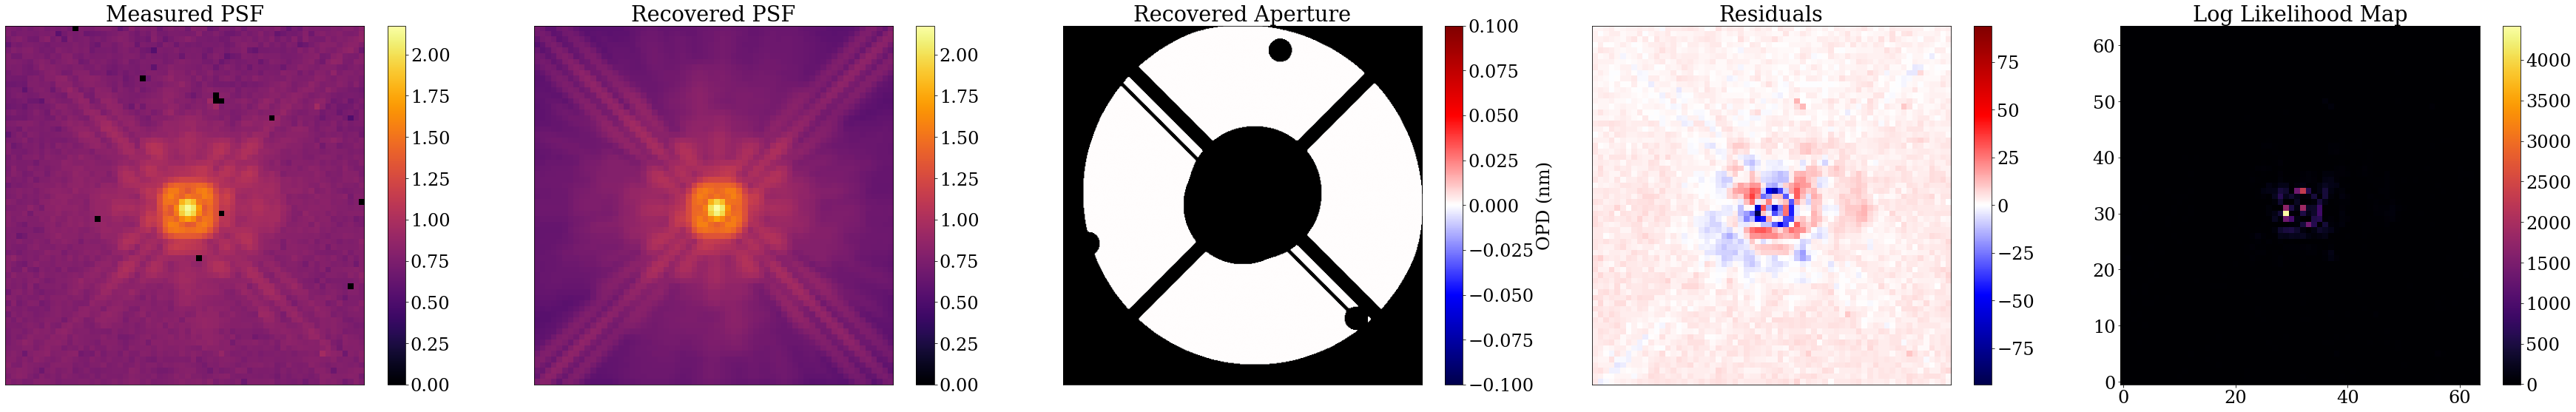

In [250]:
plot_comparison(model_single, params, exposures_single)

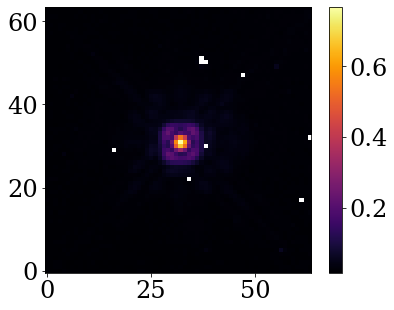

In [251]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

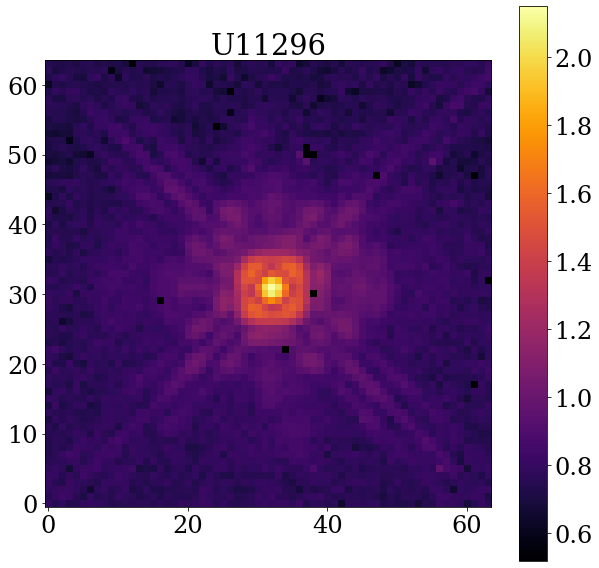

In [252]:
cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)
plt.figure(figsize=(10,10))
plt.imshow(exposures_single[0].data**0.125, cmap=cmap)
plt.title(exposures_single[0].target)
plt.colorbar()


In [253]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_sgd2 = lambda vals: optax.rmsprop(vals)

opts = lambda lr, start, *schedule: base_sgd2(scheduler(lr, start, *schedule))


base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

base_lbfgs = lambda vals: optax.lbfgs(vals)

optl = lambda lr, start, *schedule: base_lbfgs(scheduler(lr, start, *schedule))




def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-2

things = {
    "positions": opt(g*2, 0),
    "spectrum": opt(g*5, 10),#opt(g*2, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*30, 30),
    #"cold_mask_rot": opt(g*10, 100),
    "bias": opt(g*2, 20),
    "aberrations": opt(g*1, 50),

    #"cold_mask_scale": opt(g*1, 300),
    #"cold_mask_shear": opt(g*1, 300),
    #"primary_scale": opt(g*1, 300),
    #"primary_shear": opt(g*1, 300),
}


groups = list(things.keys())

In [254]:
losses, models = optimise(params, model_single, exposures_single, things, 100, recalculate=False)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting Model


  0%|          | 0/100 [00:00<?, ?it/s]

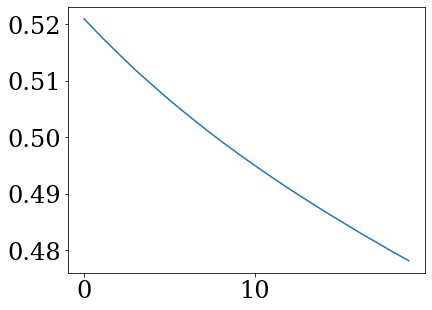

In [255]:
plt.plot(np.asarray(losses[-20:])/(len(exposures_single)*wid**2))

In [256]:
print(losses[0], losses[-1])

54887.656 1958.333


In [257]:
models_pd = [jax.tree.map(lambda x,y: (x-y)/y, models[i], models[-1]) for i in range(len(models))]

5
1.7660553


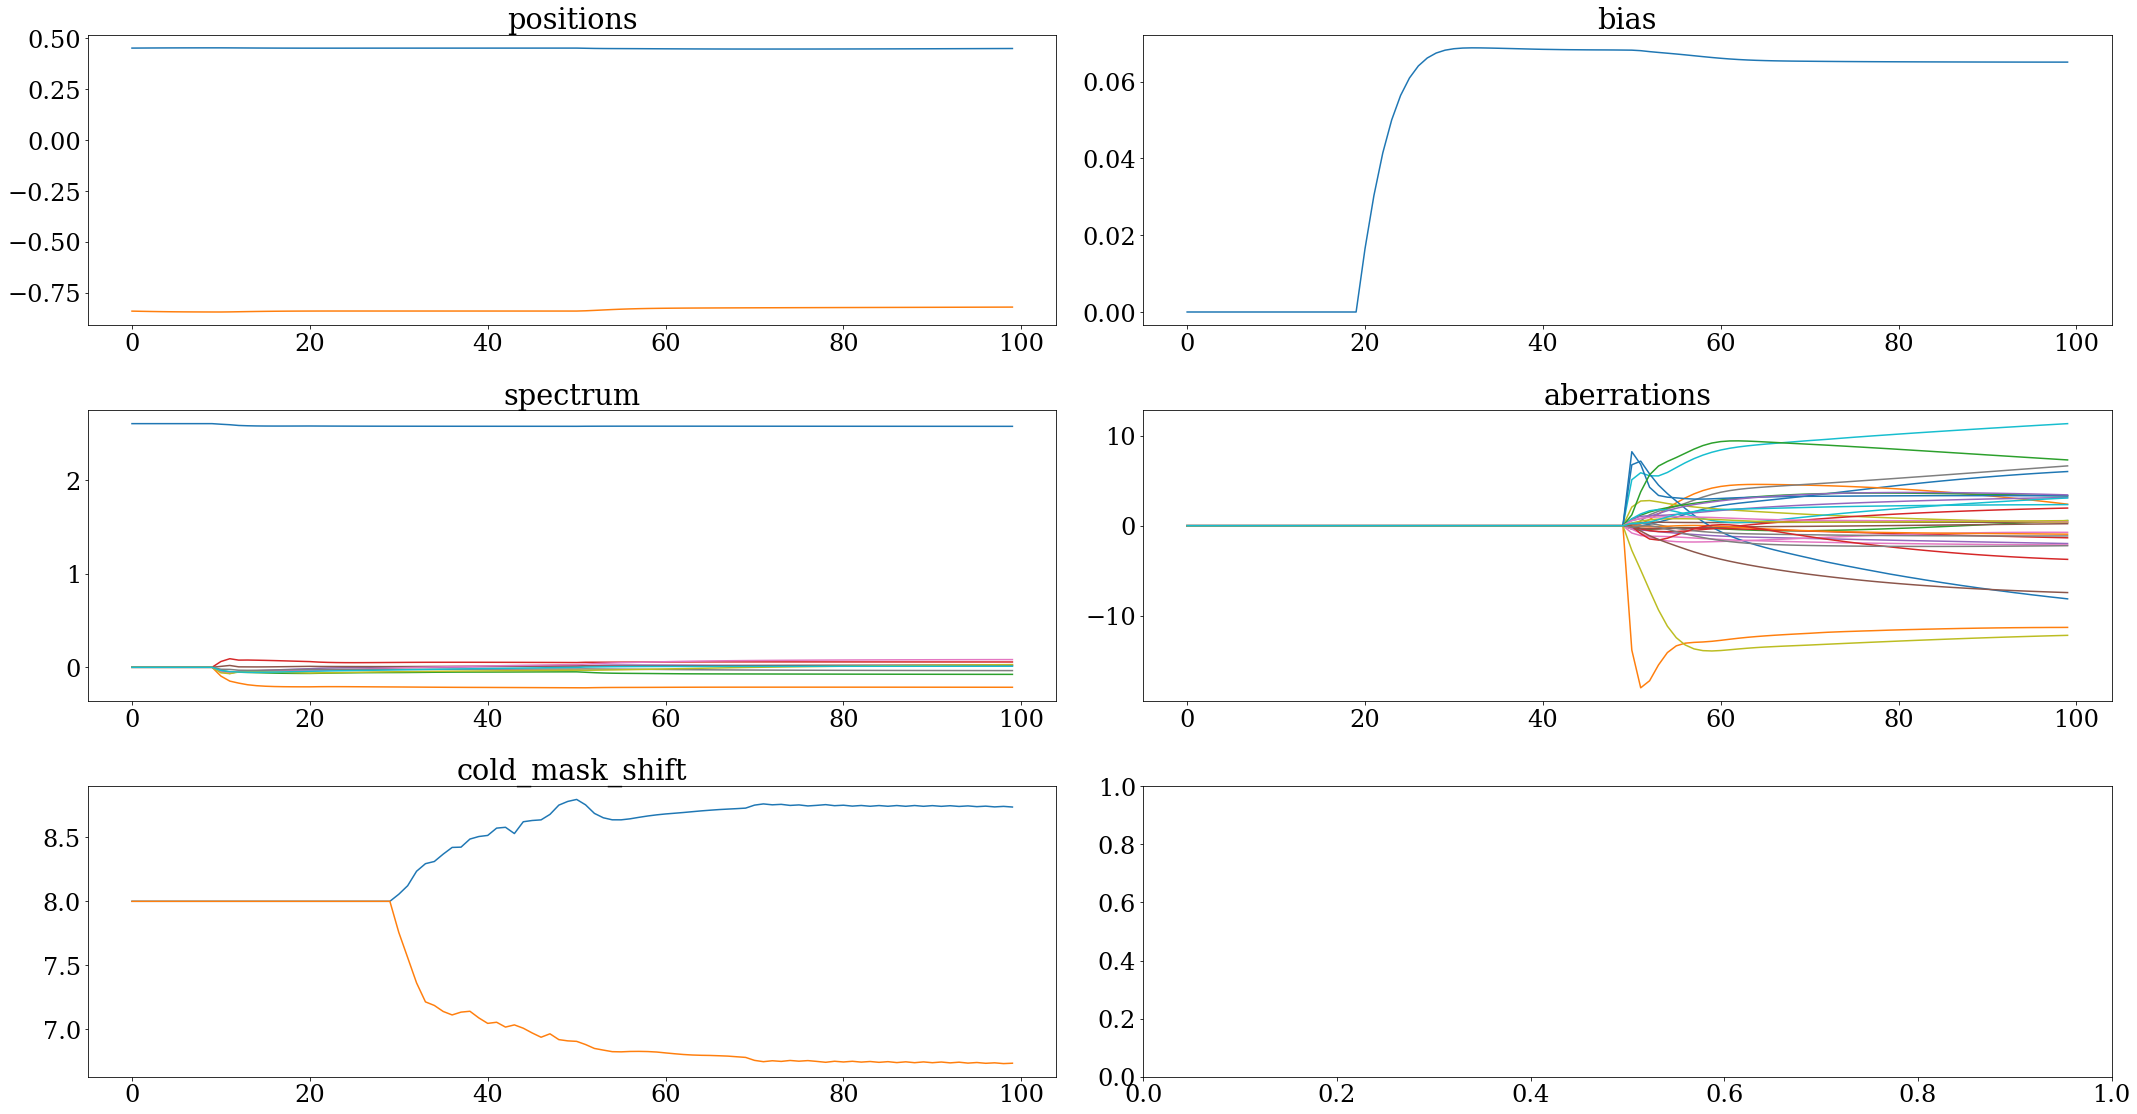

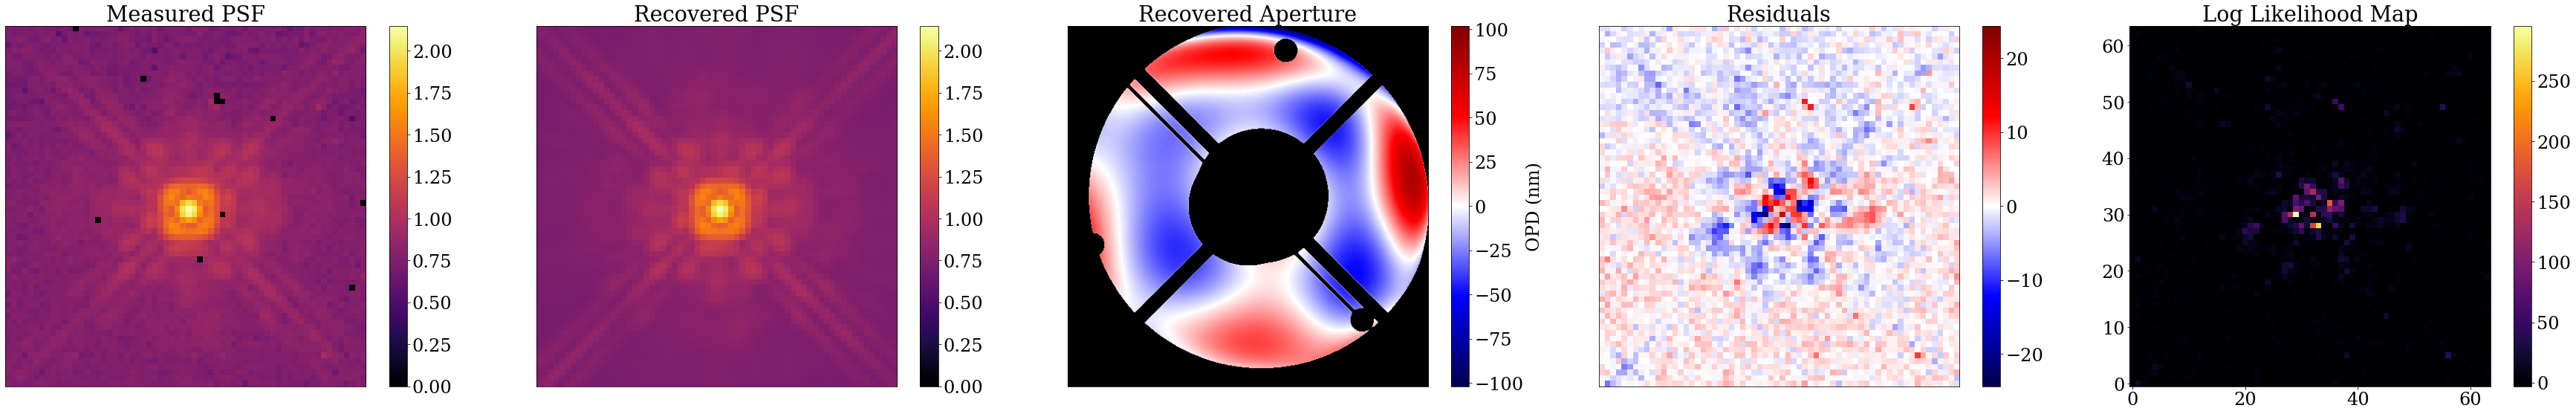

In [258]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [259]:
#stop

In [260]:
print(models[-1].params)

{'aberrations': {'n8yj02x0q': Array([  6.015849  ,   2.390351  ,   0.576186  ,  -1.3396167 ,
        -1.9748831 ,   0.39533272,  -2.130872  ,   6.64197   ,
         0.33088553,  11.330729  ,  -8.116627  , -11.283249  ,
         3.3093064 ,   1.9608381 ,   3.1309068 ,   0.22331356,
        -0.73469234,  -1.1319548 , -12.165258  ,   3.0810704 ,
         3.3180394 ,  -0.9377047 ,   7.302608  ,  -3.733871  ,
         3.425599  ,  -7.418997  ,   0.44871348,  -2.2156932 ,
         0.56549394,   2.3439205 ], dtype=float32)}, 'bias': {'n8yj02x0q': Array(0.06510978, dtype=float32)}, 'cold_mask_shift': {'53434': Array([8.736204 , 6.7357807], dtype=float32)}, 'positions': {'n8yj02x0q': Array([ 0.45009544, -0.8201575 ], dtype=float32)}, 'spectrum': {'U11296_F110W': Array([ 2.577451  , -0.21371874, -0.07578532,  0.05679011,  0.01554811,
        0.024286  ,  0.0823894 , -0.03535471,  0.02866787,  0.01139654],      dtype=float32)}}


In [261]:
models[-1].inject(model_single)

NICMOSModel(
  params={
    'aberrations': {'n8yj02x0q': f32[30]},
    'bias': {'n8yj02x0q': f32[]},
    'cold_mask_rot': {'global': f32[]},
    'cold_mask_scale': {'F110W': f32[2]},
    'cold_mask_shear': {'F110W': f32[2]},
    'cold_mask_shift': {'53434': f32[2]},
    'jitter': {'n8yj02x0q': f32[]},
    'outer_radius': f32[],
    'positions': {'n8yj02x0q': f32[2]},
    'primary_rot': {'F110W': f32[]},
    'primary_scale': {'F110W': f32[2]},
    'primary_shear': {'F110W': f32[2]},
    'scale': f32[],
    'secondary_radius': f32[],
    'softening': f32[],
    'spectrum': {'U11296_F110W': f32[10]},
    'spider_width': f32[]
  },
  filters={'F110W': f32[244,2]},
  optics=NICMOSOptics(
    wf_npixels=1024,
    diameter=f32[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=CoordTransform(
          translation=None, rotation=f32[], compression=None, shear=None
        ),
        apertures={
          'cold_mask':
          NICM

In [262]:
models[-1]

ModelParams(
  params={
    'aberrations': {'n8yj02x0q': f32[30]},
    'bias': {'n8yj02x0q': f32[]},
    'cold_mask_shift': {'53434': f32[2]},
    'positions': {'n8yj02x0q': f32[2]},
    'spectrum': {'U11296_F110W': f32[10]}
  }
)

In [295]:
groups

['positions', 'spectrum', 'cold_mask_shift', 'bias', 'aberrations']

In [299]:
fsh = calc_fishers(models[-1].inject(model_single), exposures_single, groups, fisher_fn, recalculate=True, save=False)


  0%|          | 0/1 [00:00<?, ?it/s]

In [310]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    res = np.sum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))
    return np.where(res==0.0, np.inf, res)

@eqx.filter_jit
def fun(params, args):
    exposures, model = args
    return loss_fn(params, exposures, model)

def optimise_optimistix(params, model, exposures, things, niter):
    paths = list(things.keys())
    optimisers = [things[i] for i in paths]

    model_params = ModelParams({p: params.get(p) for p in things.keys()})

    solver = optx.BFGS(rtol=1e-8, atol=1e-6,verbose=frozenset({"step_size", "loss"}))
    sol = optx.minimise(fun, solver, model_params, (exposures, model), throw=False, max_steps=niter)
    
    return sol



In [ ]:
sol = optimise_optimistix(models[-1], models[-1].inject(model_single), exposures_single, things, 5000)
print(sol.value.params)
print(fun(sol.value, (exposures_single, model_single)), (losses[-1]))

Loss on this step: 1951.296875, Loss on the last accepted step: 0.0, Step size: 1.0
Loss on this step: inf, Loss on the last accepted step: 1951.296875, Step size: 0.5
Loss on this step: inf, Loss on the last accepted step: 1951.296875, Step size: 0.25
Loss on this step: inf, Loss on the last accepted step: 1951.296875, Step size: 0.125
Loss on this step: inf, Loss on the last accepted step: 1951.296875, Step size: 0.0625
Loss on this step: inf, Loss on the last accepted step: 1951.296875, Step size: 0.03125
Loss on this step: 1813755.5, Loss on the last accepted step: 1951.296875, Step size: 0.015625
Loss on this step: 1788165.0, Loss on the last accepted step: 1951.296875, Step size: 0.0078125
Loss on this step: 1776692.375, Loss on the last accepted step: 1951.296875, Step size: 0.00390625
Loss on this step: 1770578.125, Loss on the last accepted step: 1951.296875, Step size: 0.001953125
Loss on this step: 1734737.625, Loss on the last accepted step: 1951.296875, Step size: 0.000976

In [266]:
final_params = sol.value

In [267]:
sol.stats

{'max_steps': 5000, 'num_steps': Array(485, dtype=int32, weak_type=True)}

1.7188781


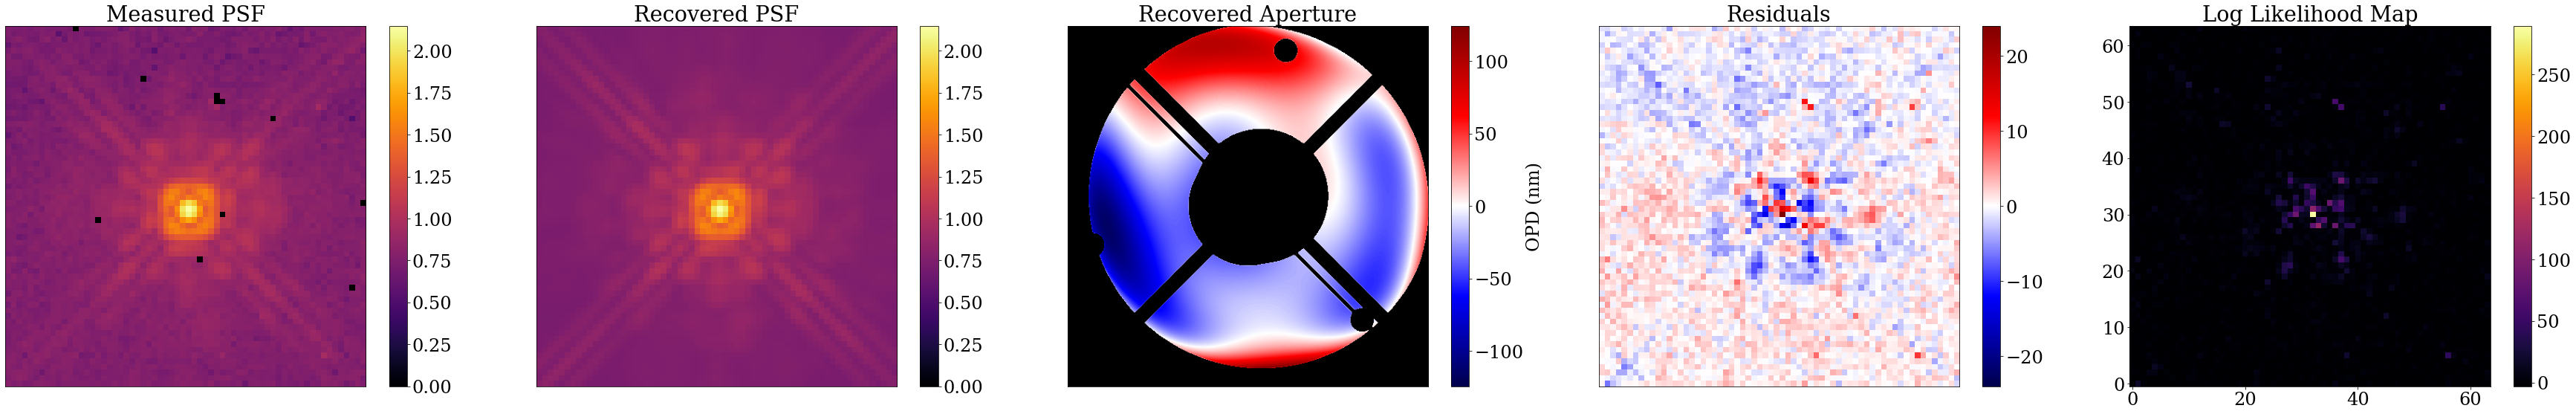

In [268]:
plot_comparison(final_params.inject(models[-1].inject(model_single)), sol.value, exposures_single)

In [269]:
final_params = sol.value

In [270]:
fsh = calc_fishers(final_params.inject(model_single), exposures_single, ["spectrum"], fisher_fn, recalculate=True, save=False)
fsh

  0%|          | 0/1 [00:00<?, ?it/s]

{'n8yj02x0q.spectrum': Array([[ 1.87791160e+07, -3.12872350e+06, -2.67622550e+06,
          3.09691525e+06, -1.25352938e+06,  1.50038188e+06,
          9.12503938e+05, -1.26702883e+05, -6.40535703e+04,
          1.68955925e+06],
        [-3.12872425e+06,  1.08413525e+06,  3.36667281e+05,
         -8.04636562e+05,  4.21690938e+05, -2.90049719e+05,
         -1.26390984e+05,  5.80459922e+04,  3.74313281e+04,
         -2.78111906e+05],
        [-2.67622350e+06,  3.36667250e+05,  6.05737000e+05,
         -4.07469844e+05,  7.21842734e+04, -1.44888625e+05,
         -1.53079172e+05,  4.60766172e+04,  1.07110273e+04,
         -2.30479578e+05],
        [ 3.09691375e+06, -8.04636312e+05, -4.07469656e+05,
          7.45084000e+05, -3.22856219e+05,  2.29274922e+05,
          1.70191547e+05, -5.24763906e+04, -1.44306855e+04,
          2.79836688e+05],
        [-1.25352988e+06,  4.21690844e+05,  7.21840469e+04,
         -3.22856094e+05,  2.34076422e+05, -1.32344969e+05,
         -6.93213281e+04,  2.6

In [271]:
spectrum_cov = np.linalg.inv(fsh['n8yj02x0q.spectrum'])#+fsh['n8yj02wyq.spectrum'])
spectrum_err = np.diag(np.sqrt(np.abs(spectrum_cov)))

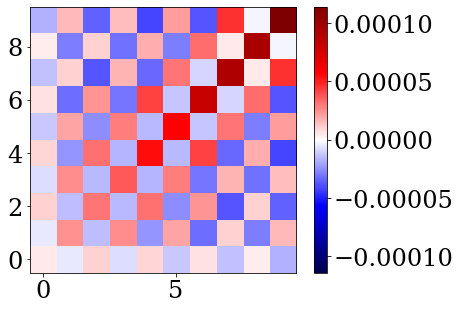

In [272]:
plt.imshow(spectrum_cov, cmap='seismic', vmin=-np.max(np.abs(spectrum_cov)), vmax=np.max(np.abs(spectrum_cov)))
plt.colorbar()


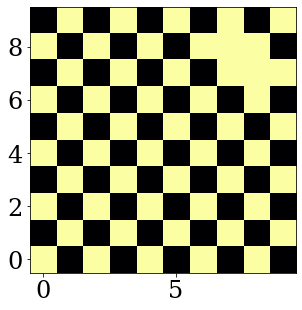

In [273]:
plt.imshow(np.sign(spectrum_cov))

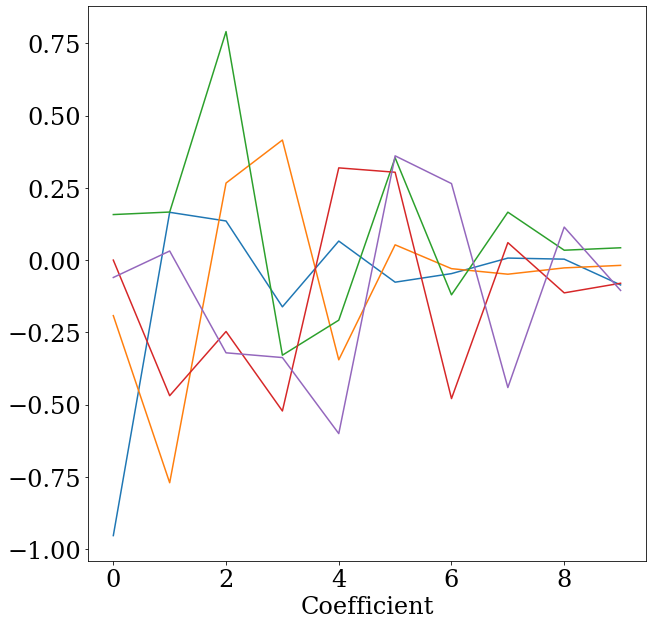

In [274]:
vals, vects = np.linalg.eig(fsh['n8yj02x0q.spectrum'])#+fsh['n8yj02wyq.spectrum'])

order = np.argsort(vals)[::-1]

plt.figure(figsize=(10,10))
plt.xlabel("Coefficient")

for i in range(5):
    plt.plot(np.arange(npoly),np.real(vects[:,order[i]]), label=f"{i}")
#plt.legend()

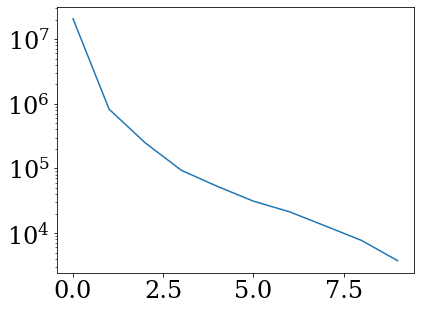

In [275]:
plt.semilogy(np.sort(np.real(vals))[::-1])

In [276]:
vals[order]

Array([2.06327640e+07+0.j, 8.24650125e+05+0.j, 2.49018750e+05+0.j,
       9.37087812e+04+0.j, 5.27967930e+04+0.j, 3.11614453e+04+0.j,
       2.13205020e+04+0.j, 1.28468545e+04+0.j, 7.68445117e+03+0.j,
       3.73611646e+03+0.j], dtype=complex64)

Text(0.5, 0, 'Wavelength (um)')

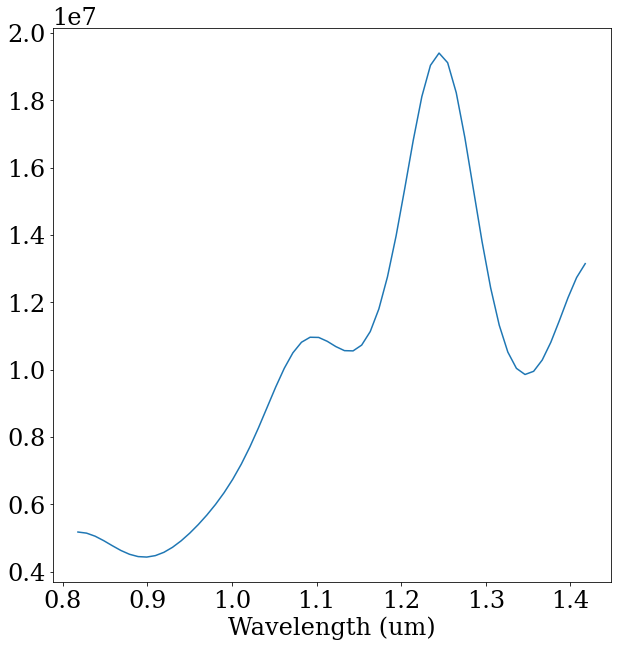

In [277]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=60)

spec = CombinedFourierSpectrum(wv, filt, final_params.get("spectrum.U11296_F110W"))

#HD201592_F110M

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv*1e6, spec.spec_weights()*spec.flux)#, yerr = spectrum_err)
plt.xlabel("Wavelength (um)")


In [278]:
symmetric_cov = spectrum_cov + spectrum_cov.T - np.diag(spectrum_cov.diagonal())

In [279]:
from jax.numpy import linalg as la
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [280]:
spec.wavelengths

Array([8.1807917e-07, 8.2823749e-07, 8.3839581e-07, 8.4855424e-07,
       8.5871250e-07, 8.6887081e-07, 8.7902919e-07, 8.8918750e-07,
       8.9934593e-07, 9.0950419e-07, 9.1966251e-07, 9.2982089e-07,
       9.3997909e-07, 9.5013752e-07, 9.6029578e-07, 9.7045427e-07,
       9.8061253e-07, 9.9077079e-07, 1.0009292e-06, 1.0110875e-06,
       1.0212458e-06, 1.0314042e-06, 1.0415625e-06, 1.0517208e-06,
       1.0618792e-06, 1.0720375e-06, 1.0821959e-06, 1.0923542e-06,
       1.1025126e-06, 1.1126708e-06, 1.1228292e-06, 1.1329876e-06,
       1.1431458e-06, 1.1533042e-06, 1.1634626e-06, 1.1736209e-06,
       1.1837792e-06, 1.1939375e-06, 1.2040960e-06, 1.2142542e-06,
       1.2244125e-06, 1.2345710e-06, 1.2447292e-06, 1.2548875e-06,
       1.2650460e-06, 1.2752042e-06, 1.2853625e-06, 1.2955209e-06,
       1.3056792e-06, 1.3158376e-06, 1.3259959e-06, 1.3361542e-06,
       1.3463126e-06, 1.3564709e-06, 1.3666292e-06, 1.3767876e-06,
       1.3869459e-06, 1.3971043e-06, 1.4072626e-06, 1.4174209e

In [281]:
final_params.get("spectrum.U11296_F110W")

Array([ 2.5728312 , -0.23441607, -0.11360418,  0.0460449 , -0.00867469,
        0.01882315,  0.05871791, -0.04452553,  0.02000373,  0.00937849],      dtype=float32)

In [282]:
wv[:-1]*1e9

Array([ 818.07916,  828.2375 ,  838.3958 ,  848.55426,  858.7125 ,
        868.8708 ,  879.0292 ,  889.1875 ,  899.34595,  909.5042 ,
        919.66254,  929.82086,  939.97906,  950.1375 ,  960.2958 ,
        970.4543 ,  980.61255,  990.7708 , 1000.92914, 1011.0875 ,
       1021.2458 , 1031.4042 , 1041.5625 , 1051.7208 , 1061.8792 ,
       1072.0376 , 1082.1959 , 1092.3541 , 1102.5126 , 1112.6708 ,
       1122.8292 , 1132.9875 , 1143.1459 , 1153.3042 , 1163.4625 ,
       1173.621  , 1183.7792 , 1193.9375 , 1204.096  , 1214.2543 ,
       1224.4125 , 1234.5709 , 1244.7292 , 1254.8875 , 1265.046  ,
       1275.2042 , 1285.3624 , 1295.5209 , 1305.6792 , 1315.8376 ,
       1325.9958 , 1336.1543 , 1346.3126 , 1356.4708 , 1366.6293 ,
       1376.7876 , 1386.9459 , 1397.1042 , 1407.2626 ], dtype=float32)

In [283]:
s = spec.spec_weights()[:-1]
s/s.sum() /( wv[:-1]*1e9 /1e4)

Array([0.1075599 , 0.10557172, 0.10244139, 0.09856234, 0.0944351 ,
       0.09055527, 0.08732765, 0.08502736, 0.08379616, 0.08365998,
       0.08455382, 0.08634894, 0.08888285, 0.09199402, 0.0955588 ,
       0.09952281, 0.10391643, 0.10884656, 0.11446347, 0.12090273,
       0.12821549, 0.13629268, 0.14480443, 0.15317683, 0.1606443 ,
       0.16638899, 0.16975969, 0.17049018, 0.16883141, 0.16552855,
       0.16165884, 0.15841095, 0.15689668, 0.15804371, 0.16255021,
       0.17085324, 0.18304676, 0.19872364, 0.21676402, 0.23518892,
       0.25125113, 0.26192933, 0.2647696 , 0.25875515, 0.24471821,
       0.22504798, 0.20284942, 0.18103342, 0.1617346 , 0.1461713 ,
       0.13481016, 0.127636  , 0.12437697, 0.12462682, 0.12786655,
       0.13341762, 0.14037459, 0.14758527, 0.15373781], dtype=float32)

Text(0, 0.5, 'Flux')

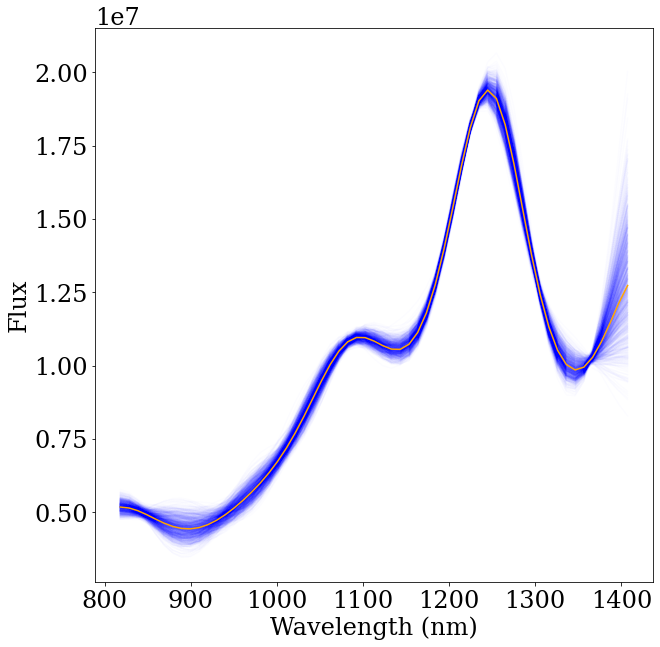

In [284]:
plt.figure(figsize=(10,10))

plt.plot(wv[:-1]*1e9, spec.spec_weights()[:-1]*spec.flux, color='orange')
for i in range(1000):
    coeffs = numpy.random.multivariate_normal(final_params.get("spectrum.U11296_F110W"), nearestPD(symmetric_cov))
    spec = CombinedFourierSpectrum(wv, filt, coeffs)
    plt.plot(wv[:-1]*1e9, spec.spec_weights()[:-1]*spec.flux, color='b', alpha=0.01, zorder=0)
    #plt.plot(wv*1e9, spec.spec_weights()*spec.flux, color='b', alpha=0.01, zorder=0)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux")


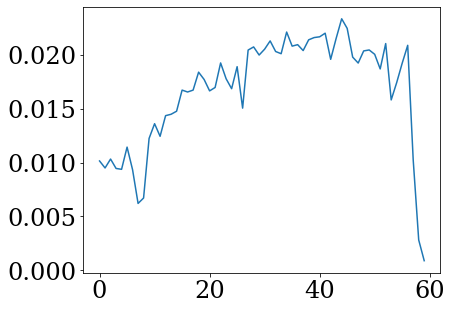

In [285]:
plt.plot(spec.filt_weights)

In [286]:
bad = np.ones((wid, wid))

In [287]:
for i in range(8):
    pst = posterior(models[-1].inject(model_single),exposures_single[0],return_im=True)
    idx = np.unravel_index(np.nanargmax(pst*bad), pst.shape)
    bad = bad.at[idx].set(np.nan)


In [288]:
extra_bad = np.isnan(bad)

In [289]:
idx

(Array(31, dtype=int32), Array(35, dtype=int32))

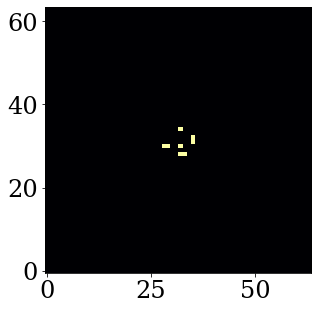

In [290]:
plt.imshow(extra_bad)

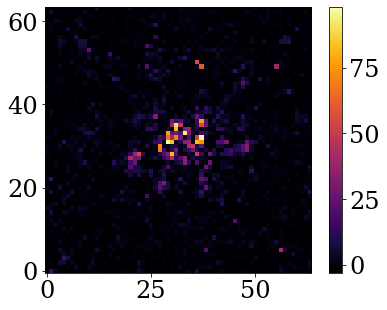

In [291]:
plt.imshow(pst*(1-extra_bad))
plt.colorbar()

In [292]:
jsp.stats.norm.logpdf(0,0,0.1)

Array(1.3836465, dtype=float32, weak_type=True)

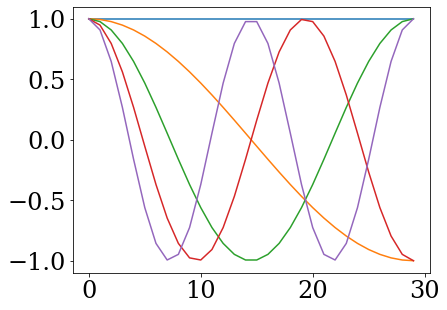

In [293]:
xs = np.linspace(0, 2*np.pi, 30)

for i,c in enumerate(np.ones(5)):
    plt.plot(np.cos(xs * i/2)*c)